In [1]:
# Australian Credit Dataset
# Necessary imports
import pandas as pd
import numpy as np
from numpy import genfromtxt
#from pymfe.mfe import MFE
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from focal_loss import BinaryFocalLoss
from tensorflow.keras.models import load_model
from scipy.io import arff
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
import random
from sklearn.model_selection import train_test_split 
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import random
random.seed(3)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
#from keras.layers import BatchNormalization,LayerNormalization
from tensorflow.keras.losses import mse, binary_crossentropy,categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
# In[5]:
import scipy.io
mat = scipy.io.loadmat('AUS_NEW.mat')


C:\Users\91948\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 518 samples in 0.002s...
[t-SNE] Computed neighbors for 518 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 518 / 518
[t-SNE] Mean sigma: 0.533747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.762047
[t-SNE] KL divergence after 1050 iterations: 0.207599
t-SNE done! Time elapsed: 2.379697561264038 seconds
(236, 2)


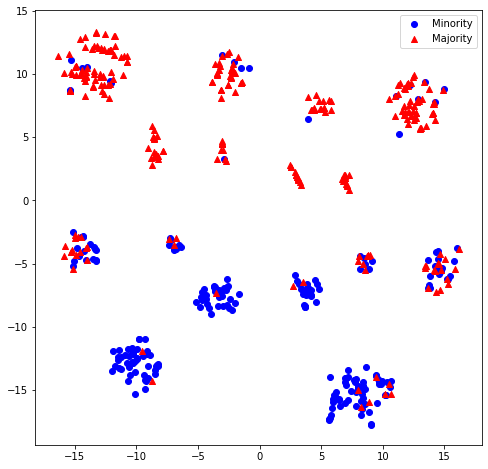

In [2]:
# In[6]:


x_train = mat['train_x'] 
ytrn = mat['train_y'] 
y_train =  ytrn[:,0]*2+ytrn[:,1]*1

x_test = mat['test_x'] 
ytst = mat['test_y'] 
y_test =  ytst[:,0]*2+ytst[:,1]*1



# ### T-SNE

# In[8]:


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_org = tsne.fit_transform(x_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","b"])
plt.figure(figsize=(8,8))
colors = ['b', 'r']

points = tsne_org[y_train ==1]
print(points.shape)
p2 = plt.scatter(points[:, 0], points[:, 1], marker=('o'), color=colors[0])
points = tsne_org[y_train == 2]
p1 = plt.scatter(points[:, 0], points[:, 1], marker=('^'), color=colors[1])
plt.legend((p2,p1),('Minority','Majority'),loc='upper right')

#plt.savefig('Aus_TSNE.png')
#plt.show()


mmscaler    = MinMaxScaler(feature_range=(-1,1))

scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)
x_train   = mmscaler.fit_transform(x_train)
x_test = mmscaler.transform(x_test)

In [3]:
# ### VAE

# In[10]:


start_dimension = x_train.shape[1]
# network parameters
input_shape = (start_dimension, )
intermediate_dim = 8
batch_size = 24
latent_dim = 5
epochs = 1000


# In[11]:


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# In[12]:


# build encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# In[13]:


# build decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(start_dimension, activation='tanh')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


# In[14]:


# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


# In[15]:


X_imtrain, X_imval, y_imtrain, y_imval = train_test_split(x_train, x_train, 
                                                    test_size=0.2, random_state=1)

start_time = time.time()
# In[16]:


if __name__ == '__main__':
    
    loss = 'mse'
    models = (encoder, decoder)
    
    if loss == 'bce':
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)
        
    reconstruction_loss *= start_dimension
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    opt = keras.optimizers.Adam(lr =0.0001)
    vae.compile(optimizer=opt,)
    vae.summary()
            
    vae.fit(X_imtrain,
            epochs=epochs,
            #verbose = 10,
            batch_size=batch_size,
            validation_data=(X_imval, None))
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            120         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            45          dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 5)            45          dense[0][0]                      
____________________________________________________________________________________________

C:\Users\91948\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


18/18 [==============================] - 1s 10ms/step - loss: 13.2703 - val_loss: 13.3422
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 13.0170 - val_loss: 13.7212
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 13.2782 - val_loss: 12.5329
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 12.6276 - val_loss: 12.9883
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 12.4078 - val_loss: 12.8214
Epoch 6/1000
18/18 [==============================] - 0s 3ms/step - loss: 12.3050 - val_loss: 12.7636
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 12.1521 - val_loss: 12.3937
Epoch 8/1000
18/18 [==============================] - 0s 2ms/step - loss: 11.9118 - val_loss: 12.3823
Epoch 9/1000
18/18 [==============================] - 0s 2ms/step - loss: 11.9717 - val_loss: 12.0455
Epoch 10/1000
18/18 [==============================] - 0s 3ms/step - loss: 11.7664 - val_loss:

Epoch 82/1000
18/18 [==============================] - 0s 3ms/step - loss: 7.2526 - val_loss: 6.9493
Epoch 83/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.1160 - val_loss: 6.8977
Epoch 84/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.1111 - val_loss: 7.0348
Epoch 85/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.1654 - val_loss: 6.9468
Epoch 86/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.1295 - val_loss: 6.8861
Epoch 87/1000
18/18 [==============================] - 0s 1ms/step - loss: 7.2225 - val_loss: 6.9811
Epoch 88/1000
18/18 [==============================] - 0s 2ms/step - loss: 6.9235 - val_loss: 6.9060
Epoch 89/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.1801 - val_loss: 7.0072
Epoch 90/1000
18/18 [==============================] - 0s 2ms/step - loss: 7.0406 - val_loss: 6.7618
Epoch 91/1000
18/18 [==============================] - 0s 2ms/step - loss: 6.9355 - val_los

18/18 [==============================] - 0s 1ms/step - loss: 5.9027 - val_loss: 5.5311
Epoch 163/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.8694 - val_loss: 5.4441
Epoch 164/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.9037 - val_loss: 5.8281
Epoch 165/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.7764 - val_loss: 5.5443
Epoch 166/1000
18/18 [==============================] - 0s 5ms/step - loss: 5.7771 - val_loss: 5.6991
Epoch 167/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.8512 - val_loss: 5.5815
Epoch 168/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.7783 - val_loss: 5.4933
Epoch 169/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.7494 - val_loss: 5.3227
Epoch 170/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.7558 - val_loss: 5.3446
Epoch 171/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.7346 - val_loss: 5.

18/18 [==============================] - 0s 2ms/step - loss: 5.2968 - val_loss: 5.0818
Epoch 243/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.3681 - val_loss: 4.9564
Epoch 244/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.2950 - val_loss: 4.8130
Epoch 245/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.2569 - val_loss: 4.9422
Epoch 246/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.3922 - val_loss: 4.8748
Epoch 247/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.3204 - val_loss: 4.9341
Epoch 248/1000
18/18 [==============================] - 0s 1ms/step - loss: 5.3505 - val_loss: 4.8146
Epoch 249/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.3258 - val_loss: 4.7979
Epoch 250/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.3016 - val_loss: 4.7516
Epoch 251/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.2886 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 5.0607 - val_loss: 4.7009
Epoch 323/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0286 - val_loss: 4.7993
Epoch 324/1000
18/18 [==============================] - 0s 1ms/step - loss: 5.0025 - val_loss: 4.9169
Epoch 325/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0715 - val_loss: 4.5342
Epoch 326/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.1395 - val_loss: 4.7312
Epoch 327/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0936 - val_loss: 4.5874
Epoch 328/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0332 - val_loss: 4.6166
Epoch 329/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0392 - val_loss: 4.6856
Epoch 330/1000
18/18 [==============================] - 0s 1ms/step - loss: 5.0420 - val_loss: 4.7358
Epoch 331/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0612 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.9430 - val_loss: 4.5890
Epoch 403/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.9912 - val_loss: 4.5056
Epoch 404/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8965 - val_loss: 4.6415
Epoch 405/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9190 - val_loss: 4.4183
Epoch 406/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9215 - val_loss: 4.4277
Epoch 407/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9679 - val_loss: 4.5440
Epoch 408/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9968 - val_loss: 4.4835
Epoch 409/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.0449 - val_loss: 4.5907
Epoch 410/1000
18/18 [==============================] - 0s 1ms/step - loss: 4.9633 - val_loss: 4.5362
Epoch 411/1000
18/18 [==============================] - 0s 2ms/step - loss: 5.0137 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.9300 - val_loss: 4.3560
Epoch 483/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9299 - val_loss: 4.4631
Epoch 484/1000
18/18 [==============================] - 0s 1ms/step - loss: 4.9198 - val_loss: 4.2730
Epoch 485/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.8339 - val_loss: 4.3419
Epoch 486/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9005 - val_loss: 4.3436
Epoch 487/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.9065 - val_loss: 4.3687
Epoch 488/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8752 - val_loss: 4.4488
Epoch 489/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8237 - val_loss: 4.4293
Epoch 490/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8091 - val_loss: 4.4774
Epoch 491/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.8950 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.7903 - val_loss: 4.3948
Epoch 563/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8037 - val_loss: 4.2194
Epoch 564/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7728 - val_loss: 4.6555
Epoch 565/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8826 - val_loss: 4.4343
Epoch 566/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8415 - val_loss: 4.3723
Epoch 567/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7754 - val_loss: 4.5179
Epoch 568/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.8102 - val_loss: 4.5034
Epoch 569/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7760 - val_loss: 4.2771
Epoch 570/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7644 - val_loss: 4.3549
Epoch 571/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7446 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.6584 - val_loss: 4.2852
Epoch 643/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6561 - val_loss: 4.3114
Epoch 644/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6399 - val_loss: 4.6521
Epoch 645/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7291 - val_loss: 4.4232
Epoch 646/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7008 - val_loss: 4.1135
Epoch 647/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7828 - val_loss: 4.2601
Epoch 648/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.6937 - val_loss: 4.3941
Epoch 649/1000
18/18 [==============================] - 0s 1ms/step - loss: 4.7595 - val_loss: 4.4545
Epoch 650/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7016 - val_loss: 4.3618
Epoch 651/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6827 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.5868 - val_loss: 4.4457
Epoch 723/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6025 - val_loss: 4.2040
Epoch 724/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6435 - val_loss: 4.0927
Epoch 725/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6278 - val_loss: 4.3340
Epoch 726/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7045 - val_loss: 4.2937
Epoch 727/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6075 - val_loss: 4.3946
Epoch 728/1000
18/18 [==============================] - ETA: 0s - loss: 4.548 - 0s 1ms/step - loss: 4.6681 - val_loss: 4.4633
Epoch 729/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6308 - val_loss: 4.5201
Epoch 730/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6357 - val_loss: 4.4011
Epoch 731/1000
18/18 [==============================] - 0s 2ms/step - los

18/18 [==============================] - 0s 2ms/step - loss: 4.6654 - val_loss: 4.3138
Epoch 803/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5311 - val_loss: 4.2298
Epoch 804/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5817 - val_loss: 4.2566
Epoch 805/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6835 - val_loss: 4.3077
Epoch 806/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5967 - val_loss: 4.2408
Epoch 807/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6198 - val_loss: 4.3151
Epoch 808/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6781 - val_loss: 4.3453
Epoch 809/1000
18/18 [==============================] - 0s 1ms/step - loss: 4.5632 - val_loss: 4.2464
Epoch 810/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6605 - val_loss: 4.4304
Epoch 811/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.7470 - val_loss: 4.

18/18 [==============================] - 0s 2ms/step - loss: 4.4825 - val_loss: 4.5068
Epoch 883/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5925 - val_loss: 4.4041
Epoch 884/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.4481 - val_loss: 4.2175
Epoch 885/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5882 - val_loss: 4.1856
Epoch 886/1000
18/18 [==============================] - 0s 4ms/step - loss: 4.5885 - val_loss: 4.2965
Epoch 887/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5674 - val_loss: 4.3386
Epoch 888/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5379 - val_loss: 4.3512
Epoch 889/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5596 - val_loss: 4.3200
Epoch 890/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6503 - val_loss: 4.3233
Epoch 891/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6464 - val_loss: 4.

18/18 [==============================] - 0s 3ms/step - loss: 4.5291 - val_loss: 4.4269
Epoch 963/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.5762 - val_loss: 4.2212
Epoch 964/1000
18/18 [==============================] - 0s 3ms/step - loss: 4.6149 - val_loss: 4.3206
Epoch 965/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5411 - val_loss: 4.2834
Epoch 966/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.4755 - val_loss: 4.1081
Epoch 967/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5113 - val_loss: 4.3707
Epoch 968/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.6404 - val_loss: 4.4226
Epoch 969/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5617 - val_loss: 4.3276
Epoch 970/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5603 - val_loss: 4.2137
Epoch 971/1000
18/18 [==============================] - 0s 2ms/step - loss: 4.5468 - val_loss: 4.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 518 samples in 0.000s...
[t-SNE] Computed neighbors for 518 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 518 / 518
[t-SNE] Mean sigma: 0.209272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.041122
[t-SNE] KL divergence after 2850 iterations: 0.072633
t-SNE done! Time elapsed: 4.199498653411865 seconds
(236, 2)
46
[0.40355383 0.37199466 0.06198569 0.00040442 0.00290215]
[False False False False False] 5
0.001619295300599114 -0.9959874119222208
[[0.40355383]
 [0.37199466]
 [0.06198569]
 [0.00290215]
 [0.00040442]]
32.199999999999996
0


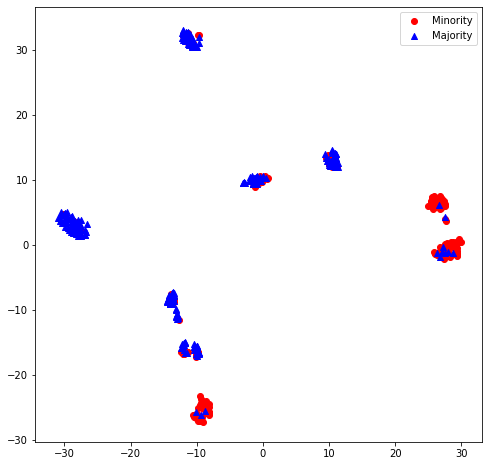

In [4]:
# Train data latent space
def latent_data(vae, data):
    encoder, decoder = vae
    z_mean, _, _ = encoder.predict(data)
    return z_mean
LS_Aus_train = latent_data(models, x_train)
LS_Aus_test = latent_data(models, x_test)


# ### T-SNE

# In[19]:


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_org = tsne.fit_transform(LS_Aus_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","b"])
plt.figure(figsize=(8,8))
colors = ['r', 'b']

points = tsne_org[y_train ==1]
print(points.shape)
p2 = plt.scatter(points[:, 0], points[:, 1], marker=('o'), color=colors[0])
points = tsne_org[y_train == 2]
p1 = plt.scatter(points[:, 0], points[:, 1], marker=('^'), color=colors[1])
plt.legend((p2,p1,),('Minority','Majority',), loc='upper right')
#plt.savefig('Aus_TSNE.png')
#plt.show()


# In[20]:




# ### MSPO

# In[24]:

latent_space_im = LS_Aus_train
mino = 1
majo = 2
y_d = y_train

nTarget = np.sum(y_d == majo)


posy = y_d == mino
negy = y_d != mino
P = latent_space_im[np.where(posy == True)[0],:]
N = latent_space_im[np.where(negy == True)[0],:]

#print(len(P),len(N))

poscnt = P.shape[0]
NumToGen = nTarget - poscnt
Me  = np.mean((P),axis = 0)
PCov = np.cov(P.T)
print(NumToGen)
[D,V] = np.linalg.eig(PCov)
#d = [D[x,x] for x in range(D.shape[0])]
d = D
print(D)
#d = d.astype(np.float32)
n = P.shape[1] #Feature dimension
idx = d.argsort()[::-1]   
d = d[idx]
V = V[:,idx]
#d = d[0:n+1]
#v = V[:,n::-1]



Ind = (d<= 5e-09)

if np.sum(Ind) != 0:
    M = (list(Ind).index(True)+1)
else:
    M = n
    
print(Ind,M)

PN = np.concatenate((P,N),axis=0)
TCov = np.cov(PN.T)
dT    = np.dot(V.T,np.dot(TCov, V))
dT = [dT[x,x] for x in range(dT.shape[0])]


#Modify the Eigen spectrum according to a 1-Parameter Model
dMod  = np.zeros((n,1))
Alpha = d[0]* d[M-1]*(M-1) /(d[0] - d[M-1]) #d[0]* d[M-1]*(M-1) /(d[0] - d[M-1])
Beta  = ((M)*d[M-1] - d[0])/(d[0] - d[M-1])
print(Alpha,Beta)

for i in range(n):
    if i<M-1:

        dMod[i] = d[i]
    else:
        dMod[i] = Alpha/(i+1+Beta)
        if dMod[i] > dT[i]:
            dMod[i] = dT[i]

R = 0.7
d = dMod
print(d)
    
########################################

import scipy
from scipy.stats import multivariate_normal
Rn = M
Un = len(Me) - M
Ptemp = P

MuR = np.zeros((Rn,1)) #mlayer#
SigmaR = np.identity((Rn)) #v_mat #

MuU = np.zeros((Un,1))
SigmaU = np.identity((Un))

SampGen = np.zeros((int(NumToGen*R), len(Me)))
SampSel = np.zeros((int(NumToGen*R), len(Me)))
Prob    = np.zeros((int(NumToGen*R),1))

cnt = 0
DD = np.sqrt(d)
MuR = MuR.reshape(MuR.shape[0],)
MuU = MuU.reshape(MuU.shape[0],)
print(R*NumToGen)

while cnt < int(R*NumToGen):
    
    if(cnt%2000 == 0):
        print(cnt)

    aR =  np.random.multivariate_normal(MuR.T, SigmaR, 1)
    #print(aR)
    #scipy.stats.multivariate_normal(MuR.T, SigmaR, 1)
    tp = multivariate_normal.pdf(aR, MuR, SigmaR) #aR.pdf(1)
    #print(tp)

    if Un > 0:
        aU = np.random.multivariate_normal(MuU, SigmaU, 1)
        #scipy.stats.multivariate_normal(MuU, SigmaU, 1)
        a = np.multiply(np.concatenate((aR,aU),axis=1).T,DD)   #The vector in Eigen transformed domain;
    else:
        a = np.multiply(aR.T,DD)
        #print(a)

    x = np.dot(a.T,V.T)+ Me
    #print(x)
    #pdb.set_trace()
    PDist = np.sqrt(np.sum(np.square((x-P)),axis=1))
    NDist = np.sqrt(np.sum(np.square((x-N)),axis=1))

    [tmp,ind]  = [np.min(NDist),np.argmin(NDist)]

    if np.min(PDist) < tmp:
        PPDist = np.sqrt(np.sum(np.square((N[ind,:]-P)),axis=1))
        if tmp >= np.min(PPDist) and tmp <= np.max(PPDist):
            SampGen[cnt,:] = x
            Prob[cnt,0] = tp  
            cnt+=1
            Ptemp = np.concatenate((Ptemp,SampGen),axis =0)

for i in range (int(R*NumToGen)):
    [tmp,ind]  = [np.min(Prob),np.argmin(Prob)]
    Prob[ind] =  np.inf
    SampSel[i,:] = SampGen[ind,:]

Ynew = SampSel #np.concatenate((SampSel,P),axis = 0)
#Total = np.concatenate((Ynew,N),axis = 0)

#return Ynew


# In[25]:


Datanew = np.concatenate((SampSel,P),axis = 0)
Total = np.concatenate((Datanew,N),axis = 0)
label = np.zeros((Total.shape[0],))
label[0:Datanew.shape[0]] = 1
label[Datanew.shape[0]:Total.shape[0]] = 2


# In[26]:

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 550 samples in 0.001s...
[t-SNE] Computed neighbors for 550 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 550 / 550
[t-SNE] Mean sigma: 0.208737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.376434
[t-SNE] KL divergence after 2550 iterations: 0.112831
t-SNE done! Time elapsed: 4.024383544921875 seconds
(268, 2)


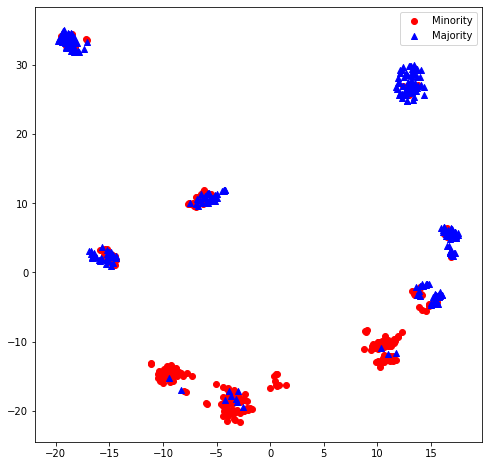

In [5]:
# ### T-SNE on MSPO

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_org = tsne.fit_transform(Total)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","b"])
plt.figure(figsize=(8,8))
colors = ['r', 'b']

points = tsne_org[label ==1]
print(points.shape)
p2 = plt.scatter(points[:, 0], points[:, 1], marker=('o'), color=colors[0])
points = tsne_org[label == 2]
p1 = plt.scatter(points[:, 0], points[:, 1], marker=('^'), color=colors[1])

plt.legend((p2,p1,),('Minority','Majority',), loc='upper right')
#plt.savefig('Aus_TSNE.png')
#plt.show()


# In[29]:

#### MLP Classifier

0.8837209302325582
              precision    recall  f1-score   support

     class 1       0.86      0.86      0.86        71
     class 2       0.90      0.90      0.90       101

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



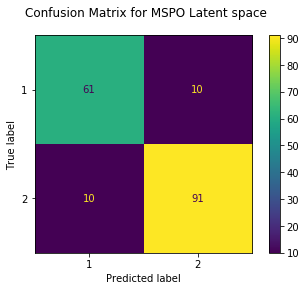

In [6]:
X_train = (Total)
y_train = (label)
X_test = (LS_Aus_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3.06,3.06))
X_trainscaled= mm_X.fit_transform(X_train) #mm_X.fit_transform(X_train)  #sc_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test) #mm_X.transform(X_test)  #sc_X.transform(X_test)
  
clf = MLPClassifier(solver='adam',batch_size= 200,hidden_layer_sizes=
                    (6,22,8,3,2),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate= 'constant',warm_start = True,
                    learning_rate_init =0.0014,
                   alpha =0.0000999,beta_1=0.9,beta_2=0.999,)

clf.fit(X_trainscaled, y_train)

y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["1",'2'])#,'5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for MSPO Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class 1', 'class 2']#,'class 5','class 6','class 7','class 8','class 9']
print(classification_report(y_pred,y_test, target_names=target_names))

# In[30]:

#### Evaluation Metric

In [7]:
def metricFn(y_test, y_pred):
    
    confMat=confusion_matrix(y_test, y_pred) 
    #print(confMat)
    TP = confMat[0,0]
    TN = confMat[1,1]
    FP = confMat[1,0]
    FN = confMat[0,1]
    #print(TP,FP,TN,FN)
    Eta = 1/2*((TP/np.sum(y_test==1))+(TN/np.sum(y_test==2)))
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    Gmean = np.sqrt(TPR*TNR)
    return (TPR,TNR,Gmean,Eta)
# print('TPR , TNR , GM ,Eta')
# print(metricFn(y_test, y_pred))


#### Cross validation

In [8]:
kf = KFold(n_splits=10,shuffle = True)
print("Cross Validation")
print('TPR , TNR , GM ,Eta')

for train_indices, test_indices in kf.split(X_trainscaled):
    clf.fit(X_trainscaled[train_indices], y_train[train_indices])
    # print(clf.score(X_testscaled, y_test))

    y_pred=clf.predict(X_testscaled)
    print(metricFn(y_test, y_pred))
    

Cross Validation
TPR , TNR , GM ,Eta
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.8450704225352113, 0.900990099009901, 0.8725824222790297, 0.8730302607725562)
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.9014084507042254, 0.900990099009901, 0.9011992505813359, 0.9011992748570632)
(0.8450704225352113, 0.900990099009901, 0.8725824222790297, 0.8730302607725562)
(0.8450704225352113, 0.900990099009901, 0.8725824222790297, 0.8730302607725562)
(0.8873239436619719, 0.900990099009901, 0.8941309120334985, 0.8941570213359364)


In [9]:
print("Time taken:",time.time()-start_time)

Time taken: 50.801310777664185
